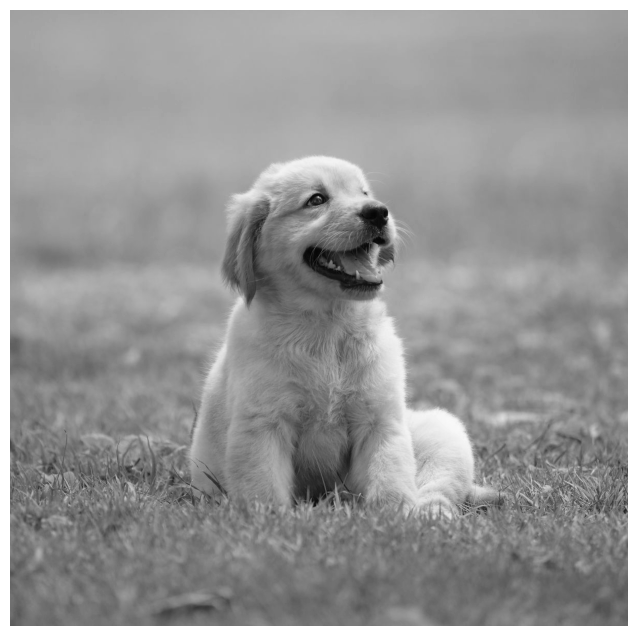

In [2]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['figure.figsize'] = [16, 8]
A = imread(os.path.join('.','dog.jpg'))
X = np.mean(A, -1); # Convert RGB to grayscale
img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

In [4]:
# Compute the Economy SVD
U, S, VT = np.linalg.svd(X,full_matrices=False)

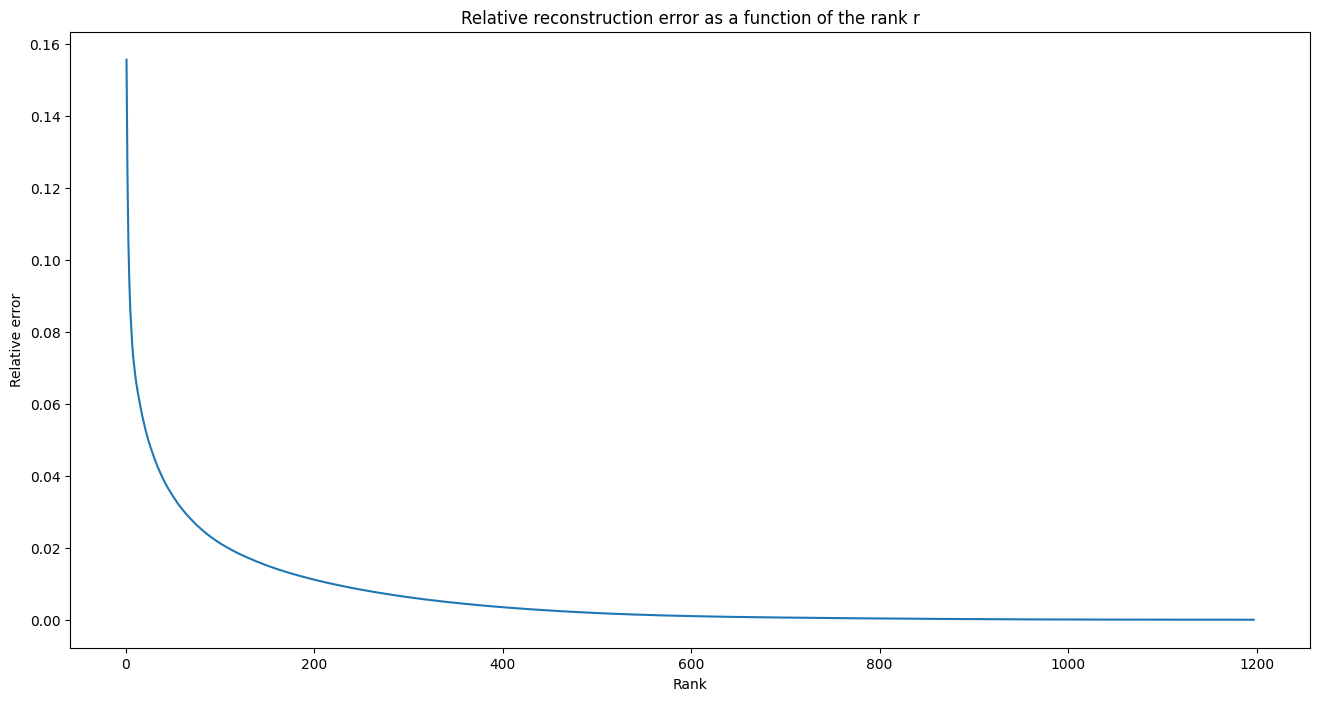

In [26]:
#Compute and plot the relative reconstruction error of the truncated SVD in the Frobenius norm as a function of the rank r.

reconstruction_errror = lambda X_hat: np.linalg.norm(X-X_hat)/np.linalg.norm(X)

errors = []
ranks = range(1, len(S)+1)
for r in ranks:
    X_hat = U[:,:r] @ np.diag(S[:r]) @ VT[:r,:]
    errors.append(reconstruction_errror(X_hat))
    
plt.plot(ranks, errors)
plt.xlabel("Rank")
plt.ylabel("Relative error")
plt.title("Relative reconstruction error as a function of the rank r")
plt.show()

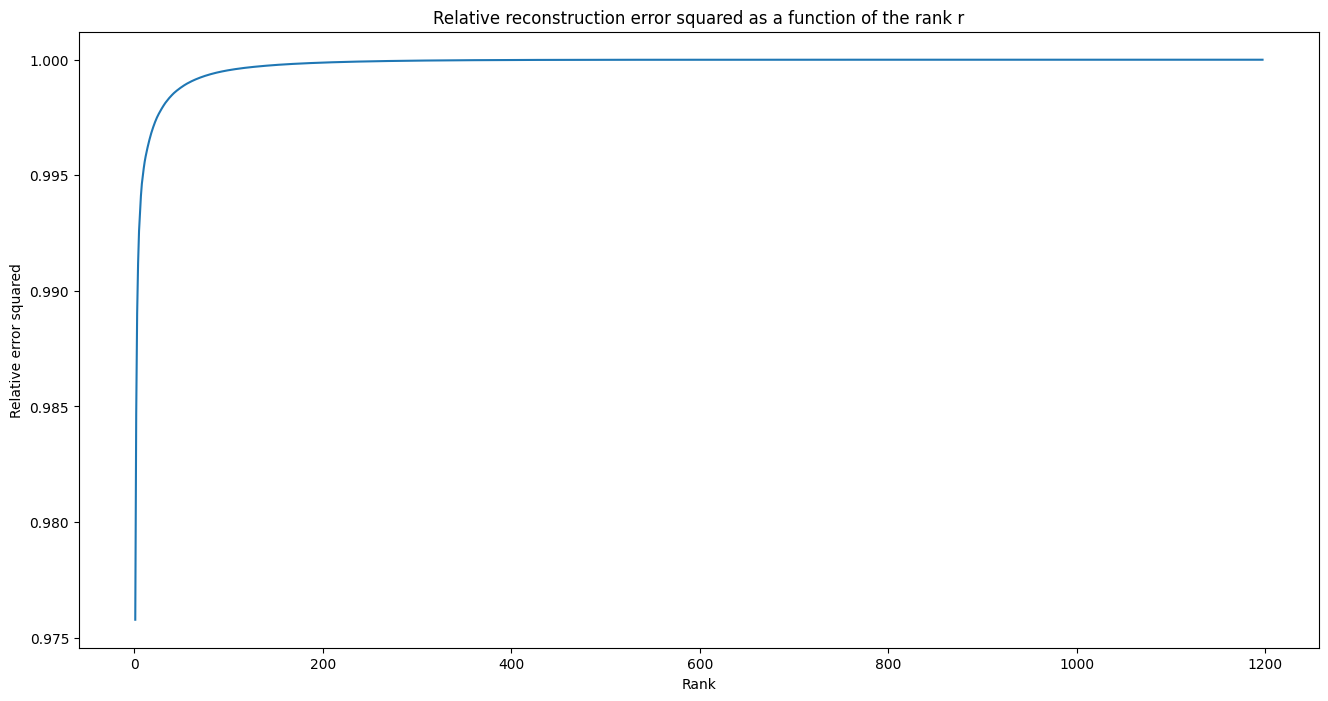

In [42]:
# square the error and plot it
square_errors = np.square(errors)
plt.plot(ranks, 1 - square_errors)
plt.xlabel("Rank")
plt.ylabel("Relative error squared")
plt.title("Relative reconstruction error squared as a function of the rank r")
plt.show()

In [44]:
# Find the rank r_v such that 99% of the total variance is captured
r_v = np.argmax(1 - np.array(square_errors) >= 0.99) + 1  # +1 to correct the index
# Return r_v and the exact percentage of variance captured
r_v, 1 - square_errors[r_v - 1]

(4, 0.9911921397407237)

In [45]:
r_f = np.argmax(1 - np.array(errors) > 0.99) + 1  # +1 to correct the index
# Return r_v and the exact error
r_f, 1 - errors[r_f - 1]

(219, 0.990023052728904)

In [46]:
frac_cumsum = np.cumsum(S**2)/np.sum(S**2)
r_c = np.argmax(frac_cumsum >= 0.99) + 1  # +1 to correct the index
# Return r_c and the exact percentage of variance captured
r_c, frac_cumsum[r_c - 1]

(4, 0.9911921397407236)

# Exercise 2

In [47]:
import jax
import jax.numpy as jnp

In [51]:
from sympy import symbols, diff

# Define the symbols
x, y = symbols('x y')

# Define the function f(x,y)
f = 100*(y - x**2)**2 + (1 - x)**2

# Compute the gradient of f
grad_f = [diff(f, var) for var in (x, y)]

# Compute the Hessian matrix of f
hessian_f = [[diff(g, var) for var in (x, y)] for g in grad_f]

grad_f, hessian_f


([-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y],
 [[1200*x**2 - 400*y + 2, -400*x], [-400*x, 200]])

In [52]:
# solve grad_f = 0
from sympy.solvers import solve
sol = solve(grad_f, x, y)
sol

[(1, 1)]

In [54]:
# With the critical point [(1,1)], we can compute the Hessian matrix at this point
[[h.subs({x: 1, y: 1}) for h in row] for row in hessian_f]

[[802, -400], [-400, 200]]

Given that the determinant of the Hessian matrix is positive and the trace is positive we can conclude that the critical point is a local minimum.
We can also conclude that the function is convex.

Given that we only have one critical point, we can conclude that it is a global minimum.

In [65]:
def fn(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

In [83]:
# Implement GD
max_iter = 50000 # maximum number of iterations
tol = 1e-8 # tolerance for the stopping criterium
x_0 = np.array([-1.2,1.2]) # initial guess
stepsize = 0.001 # constant stepsize

grad_f = jax.grad(fn)
grad_f = jax.jit(grad_f)

In [84]:
x_old = x_0
for i in range(max_iter):
    x_new = x_old - stepsize * grad_f(x_old)
    if np.abs(fn(x_new) - fn(x_old)) < tol:
        break
    x_old = x_new
    
print("The algorithm stopped after", i, "iterations")
print("The optimal point is", x_new)

The algorithm stopped after 12017 iterations
The optimal point is [0.99646014 0.9929186 ]


In [85]:
h = np.array([[h.subs({x: 1, y: 1}) for h in row] for row in hessian_f])
# change h dtype to float
h = h.astype(int)
h

array([[ 802, -400],
       [-400,  200]])

In [86]:
# compute the eigenvalues of the h
eigvals, _ = np.linalg.eig(h)
eigvals

array([1.00160064e+03, 3.99360767e-01])

In [87]:
f'The function {"is" if np.all(eigvals > 0) else "is not"} positive-definite'

'The function is positive-definite'

In [88]:
H_inv = np.linalg.inv(h)
# Implement GD
max_iter = 50000 # maximum number of iterations
tol = 1e-8 # tolerance for the stopping criterium
x_0 = np.array([-1.2,1.2]) # initial guess
stepsize = 0.001 # constant stepsize
tol_2 = 1e-4 # tolerance for changing the descent direction

grad_f = jax.grad(fn)
grad_f = jax.jit(grad_f)

In [93]:
x_new = x_0
for i in range(max_iter):
    epsilon = np.abs(fn(x_new) - fn(x_old))
    x_old = x_new
    if epsilon < tol:
        break
    elif epsilon < tol_2:
        x_new = x_old - H_inv @ grad_f(x_old)
    else:
        x_new = x_old - stepsize * grad_f(x_old)
    
    
print("The algorithm stopped after", i, "iterations")
print("The optimal point is", x_new)

The algorithm stopped after 2129 iterations
The optimal point is [1. 1.]
